# 0. Overview

Based on my analysis of the Ex_3 image classification code, I can suggest several improvements to make the model perform better and more efficiently.

# 1. Data Loading and Preprocessing

- Proper data loading and concatenation
- Clean train/val/test split with stratification (70/15/15)

**Using google colab**

```
drive/MyDrive/Data/bean-leaf-lesions-classification/
├── train/
│   ├── angular_leaf_spot/
│   │   ├── angular_leaf_spot_train.0.jpg
│   │   ├── angular_leaf_spot_train.1.jpg
│   │   └── ...
│   ├── bean_rust/
│   │   ├── bean_rust_train.0.jpg
│   │   ├── bean_rust_train.1.jpg
│   │   └── ...
│   └── healthy/
│       ├── healthy_train.0.jpg
│       ├── healthy_train.1.jpg
│       └── ...
└── test/
    ├── angular_leaf_spot/
    │   ├── angular_leaf_spot_test.0.jpg
    │   ├── angular_leaf_spot_test.1.jpg
    │   └── ...
    ├── bean_rust/
    │   ├── bean_rust_test.0.jpg
    │   ├── bean_rust_test.1.jpg
    │   └── ...
    └── healthy/
        ├── healthy_test.0.jpg
        ├── healthy_test.1.jpg
        └── ...
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: cookiett
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


**Move Move the dataset into your Google Drive**

If you want to keep the dataset in Drive:

In [ ]:
!mv bean-leaf-lesions-classification /content/drive/MyDrive/Data

In [ ]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torchvision import models # import pretrained models in PyTorch library
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print(f"Using device: {device}")

Using device: cuda


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Data/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/Data/bean-leaf-lesions-classification/val.csv")

data_df = pd.concat([train_df, val_df], ignore_index=True)
data_df["image:FILE"] = "/content/drive/MyDrive/Data/bean-leaf-lesions-classification/" + data_df["image:FILE"]

print("Data shape is: ", data_df.shape)
print()
data_df.head()

Data shape is:  (1167, 2)



,image:FILE,category
0,/content/drive/MyDrive/Data/bean-leaf-lesions-...,0
1,/content/drive/MyDrive/Data/bean-leaf-lesions-...,0
2,/content/drive/MyDrive/Data/bean-leaf-lesions-...,0
3,/content/drive/MyDrive/Data/bean-leaf-lesions-...,0
4,/content/drive/MyDrive/Data/bean-leaf-lesions-...,0


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
train_df, temp_df = train_test_split(data_df, test_size=0.3, stratify=data_df['category'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['category'], random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 816
Validation samples: 175
Testing samples: 176


If you also want a 70/15/15 split using **only pandas**, you can just repeat the same trick on the leftover 30%:

```
# 1) train = 70%, remainder = 30%
train = data_df.sample(frac=0.7, random_state=7)
remainder = data_df.drop(train.index)

# 2) split remainder equally into val/test (each ~15% of original)
val  = remainder.sample(frac=0.5, random_state=7)
test = remainder.drop(val.index)

print(len(train), len(val), len(test))  # roughly 70/15/15
```

# 2. Dataset & Transforms:

- Label encoder correctly fitted on the full dataset once
- Fixed the normalization by removing the manual division by 255
- Appropriate simpler transforms for validation/testing
- Strong data augmentation pipeline for training
  - Data augmentation can significantly improve model generalization, especially with limited training data.

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['category']) # Fit the label encoder once on all categories

class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe['category'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [ ]:
# Enhanced data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Keep validation transforms simpler
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [ ]:
train_dataset = CustomImageDataset(dataframe=train_df, transform=train_transform)
val_dataset = CustomImageDataset(dataframe=val_df, transform=val_transform)
test_dataset = CustomImageDataset(dataframe=test_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Model Selection and Fine-tuning

Instead of using GoogLeNet, we could use a more recent model architecture with better performance.

- EfficientNet-B0 with proper transfer learning setup
- Strategic layer freezing to prevent overfitting
- Dropout in the classifier for regularization
- Adding a learning rate scheduler can help converge faster and achieve better results

In [ ]:
# Use a more modern architecture like EfficientNet or ResNet
model = models.efficientnet_b0(pretrained=True)

# Freeze early layers to prevent overfitting
for param in list(model.parameters())[:-30]:  # Freeze all but the last few layers
    param.requires_grad = False

# Replace classifier
num_classes = len(data_df["category"].unique())
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 164MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Optimizer with weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

# Cross Entropy Loss function
criterion = nn.CrossEntropyLoss()

# 4. Training Pipeline:

- Mixed precision training with autocast and GradScaler
- Early stopping with best model saving
- ReduceLROnPlateau scheduler properly configured
- Clean training/validation loops with metric tracking

In [ ]:
# Create a complete training function that integrates early stopping and mixed precision
# Add this after defining the model, optimizer, and criterion

from torch.amp import autocast, GradScaler

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15, patience=5):
    # Initialize the scaler for mixed precision
    scaler = GradScaler()

    best_val_loss = float('inf')
    counter = 0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Mixed precision training
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Scale the loss and do backward pass
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100. * correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        # Update learning rate
        scheduler.step(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_losses, train_accs, val_losses, val_accs

# 5. Evaluation & Visualization:

- Separate evaluation function for test set
- Clear visualization of training metrics

In [ ]:
# Add a proper evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100. * correct / total
    print(f'Test Accuracy: {test_acc:.2f}%')
    return test_acc

In [ ]:
# Add a cell to run the training
model, train_losses, train_accs, val_losses, val_accs = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=EPOCHS,
    patience=5
)

<ipython-input-19-17a630ccb65c>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-19-17a630ccb65c>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/15:
Train Loss: 0.8013, Train Acc: 64.46%
Val Loss: 0.4065, Val Acc: 82.29%
Saved best model with validation loss: 0.4065
Epoch 2/15:
Train Loss: 0.6395, Train Acc: 75.74%
Val Loss: 0.2777, Val Acc: 91.43%
Saved best model with validation loss: 0.2777
Epoch 3/15:
Train Loss: 0.6056, Train Acc: 76.10%
Val Loss: 0.2229, Val Acc: 93.71%
Saved best model with validation loss: 0.2229
Epoch 4/15:
Train Loss: 0.5085, Train Acc: 79.17%
Val Loss: 0.2131, Val Acc: 92.00%
Saved best model with validation loss: 0.2131
Epoch 5/15:
Train Loss: 0.5378, Train Acc: 78.43%
Val Loss: 0.2064, Val Acc: 91.43%
Saved best model with validation loss: 0.2064
Epoch 6/15:
Train Loss: 0.4646, Train Acc: 82.23%
Val Loss: 0.2117, Val Acc: 93.14%
Epoch 7/15:
Train Loss: 0.4686, Train Acc: 79.17%
Val Loss: 0.2668, Val Acc: 89.71%
Epoch 8/15:
Train Loss: 0.4225, Train Acc: 82.84%
Val Loss: 0.1981, Val Acc: 93.14%
Saved best model with validation loss: 0.1981
Epoch 9/15:
Train Loss: 0.4359, Train Acc: 83.58%
Va

In [ ]:
# Add a cell to evaluate on test set
test_acc = evaluate_model(model, test_loader)

Test Accuracy: 89.20%


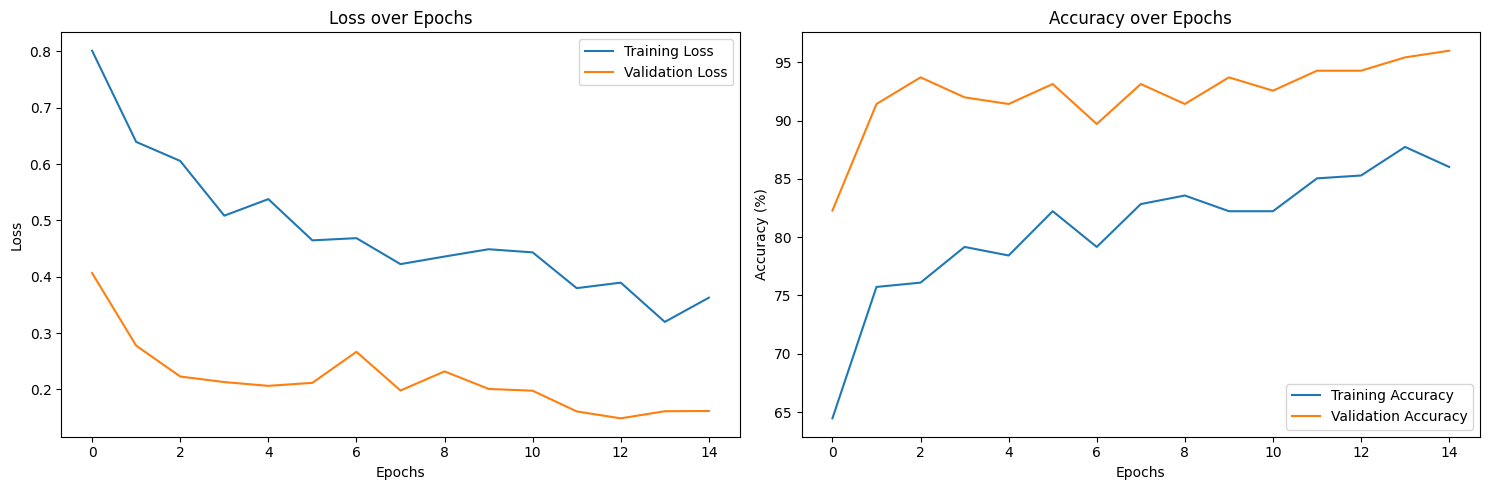

In [ ]:
# Add a cell to visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# 6. Save and Load the Model

- creating a dedicated directory for model checkpoints to keep your workspace organized

In [ ]:
import os
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/best_model.pth')

These improvements should significantly enhance the performance and efficiency of your image classification model. The combination of better data augmentation, modern architectures, proper training techniques, and ensemble methods will likely lead to higher accuracy and better generalization.